In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from IPython.lib.display import Audio


In [2]:
features_df = pd.read_csv("features_df.csv")
labels_df = features_df['label']
features_df.drop('label',axis=1, inplace=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=42)
texts_train = X_train['text'].to_list()
texts_test = X_test['text'].to_list()
X_train.drop('text', axis=1, inplace=True)
X_test.drop('text', axis=1, inplace=True)

In [4]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train+texts_test)


In [5]:
def preprocess_dataset(df_train, df_test):

    standard_scaler = preprocessing.StandardScaler()
    df_train_scaled = standard_scaler.fit_transform(df_train)
    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.text = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.text[idx], self.labels[idx]

def intialise_loaders(X_train, y_train, X_test, y_test, batch_size):
    train_data = CustomDataset(X_train, y_train)
    test_data = CustomDataset(X_test, y_test)
    train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
    return train_dataloader, test_dataloader

In [6]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [7]:
# Define the MLP model
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        layers = []
        parameters = [no_features] + no_hidden
        for i in range(len(parameters) - 1):
            layers.append(nn.Linear(parameters[i], parameters[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        
        self.mlp_stack = nn.Sequential(*layers)
        self.fc = nn.Linear(parameters[-1], no_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.mlp_stack(x)
        u = self.fc(x1)
        y = self.softmax(u)
        return y
    
# Define the CNN model for NLP processing
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])   
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = x.unsqueeze(1)  
        embedded = self.embedding(x)  
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  
        cat = self.dropout(torch.cat(pooled, dim=1))  
        output = self.fc(cat)  
        return output
    
# Define the fusion layer
class FusionLayer(nn.Module):
    def __init__(self, audio_input_size, text_input_size, output_size, audio_weight=1.0, text_weight=0.0):
        super(FusionLayer, self).__init__()
        self.fc_audio = nn.Linear(audio_input_size, output_size)
        self.fc_text = nn.Linear(text_input_size, output_size)
        self.audio_weight = audio_weight
        self.text_weight = text_weight

    def forward(self, audio_features, text_features):
        audio_out = self.fc_audio(audio_features)
        text_out = self.fc_text(text_features)
        # Apply weight to audio features
        audio_out_weighted = self.audio_weight * audio_out
        # Apply weight to text features
        text_out_weighted = self.text_weight * text_out
        fused_output = audio_out_weighted + text_out_weighted
        return fused_output




In [8]:
def train_model(cnn_model, train_dataloader, test_dataloader, loss_fn, optimizer):
    num_epochs = 100
    early_stopping = EarlyStopping(patience=3)

    training_losses = []
    training_accuracy = []
    validation_losses = []
    validation_accuracy = []
    for epoch in (range(num_epochs)):
        cnn_model.train()   
         
        training_loss = 0
        training_correct_preds = 0
        total = 0
        
        # training
        for texts, labels in train_dataloader:

            # forward pass
            text_features = cnn_model(texts)
            loss = loss_fn(text_features, labels)

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # track loss and accuracy
            training_loss += loss.item()
            _, predicted = torch.max(text_features.data, 1)
            total += labels.size(0)
            training_correct_preds += (predicted == labels).sum().item()
            
            
        training_losses.append(training_loss / len(train_dataloader))
        training_accuracy.append(training_correct_preds / len(train_dataloader.dataset))
            
        # validation
        cnn_model.eval() 
        with torch.no_grad():
            validation_loss = 0
            validation_correct_preds = 0
            for texts, labels in test_dataloader:
                text_features = cnn_model(texts)
                loss = loss_fn(text_features, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(text_features.data, 1)
                validation_correct_preds += (predicted == labels).sum().item()
        
        validation_losses.append(validation_loss / len(test_dataloader))
        validation_accuracy.append(validation_correct_preds / len(test_dataloader.dataset))
        # Check if validation loss is decreasing
        early_stopping(validation_loss, cnn_model)
        
        if early_stopping.early_stop:
            break

    return validation_accuracy[-1]

In [9]:
def find_optimal_hyperparameter(X_train, y_train, filters, batch_size):
    cross_validation_accuracies = {}
    n_splits = 5
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    X_train_folds = []
    X_val_folds = []
    y_train_folds = []
    y_val_folds = []
    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X_train, y_train):
        X_batch_train, X_batch_val = X_train[train_index], X_train[val_index]
        y_batch_train, y_batch_val = y_train[train_index], y_train[val_index]
        
        # Tokenize the text data in each fold
        X_train_tokenized = tokenizer.texts_to_sequences(X_batch_train)
        max_length_train = max([len(seq) for seq in X_train_tokenized])
        padded_sequences_train = pad_sequences(X_train_tokenized, maxlen=max_length_train)
        
        X_val_tokenized = tokenizer.texts_to_sequences(X_batch_val)
        max_length_test = max([len(seq) for seq in X_val_tokenized])
        padded_sequences_test = pad_sequences(X_val_tokenized, maxlen=max_length_test)
        
        X_train_folds.append(padded_sequences_train)
        X_val_folds.append(padded_sequences_test)
        y_train_folds.append(y_batch_train)
        y_val_folds.append(y_batch_val)




    for filter in filters:
        print(f'Starting {filter}')
        test_accuracies = []
        for i in tqdm(range(len(X_train_folds))):
            X_train_fold = X_train_folds[i]
            y_train_fold = y_train_folds[i]
            X_val_fold = X_val_folds[i]
            y_val_fold = y_val_folds[i]
            
        
            train_dataloader, test_dataloader = intialise_loaders(X_train_fold,y_train_fold,X_val_fold,y_val_fold,batch_size)
            # Define hyperparameters
            num_classes = len(np.unique(y_train))
            learning_rate = 0.001
            vocab_size = len(tokenizer.word_index) + 1
            embedding_dim = 300
            filter_sizes = [3, 4, 5]
            dropout = 0.5

            # Define the models
            cnn_model = CNN(vocab_size, embedding_dim, filter, filter_sizes, num_classes, dropout)


            # Define loss function and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.Adam(list(cnn_model.parameters()), lr=learning_rate)

            test_accuracy = train_model(cnn_model, train_dataloader, test_dataloader, loss_fn, optimizer)
            test_accuracies.append(test_accuracy)
          
        cross_validation_accuracies[filter] = np.mean(test_accuracies)
        print(f'Mean Cross Validation accuracy: {np.mean(test_accuracies)}\n')
    return cross_validation_accuracies


optimal_bs = 32 

filters = [25, 50, 100, 150, 200, 250, 300]
cross_validation_accuracies = find_optimal_hyperparameter(np.array(texts_train), y_train_encoded, filters, optimal_bs)


Starting 25


100%|██████████| 5/5 [13:28<00:00, 161.79s/it]


Mean Cross Validation accuracy: 0.6283359354721235

Starting 50


100%|██████████| 5/5 [09:09<00:00, 109.85s/it]


Mean Cross Validation accuracy: 0.6366936436787398

Starting 100


100%|██████████| 5/5 [08:45<00:00, 105.20s/it]


Mean Cross Validation accuracy: 0.6361392525211044

Starting 150


100%|██████████| 5/5 [08:54<00:00, 106.97s/it]


Mean Cross Validation accuracy: 0.6347399088024608

Starting 200


100%|██████████| 5/5 [08:01<00:00, 96.39s/it]


Mean Cross Validation accuracy: 0.6269443400575698

Starting 250


100%|██████████| 5/5 [08:58<00:00, 107.75s/it]


Mean Cross Validation accuracy: 0.6180349525997497

Starting 300


100%|██████████| 5/5 [18:42<00:00, 224.42s/it]

Mean Cross Validation accuracy: 0.6177598878045568



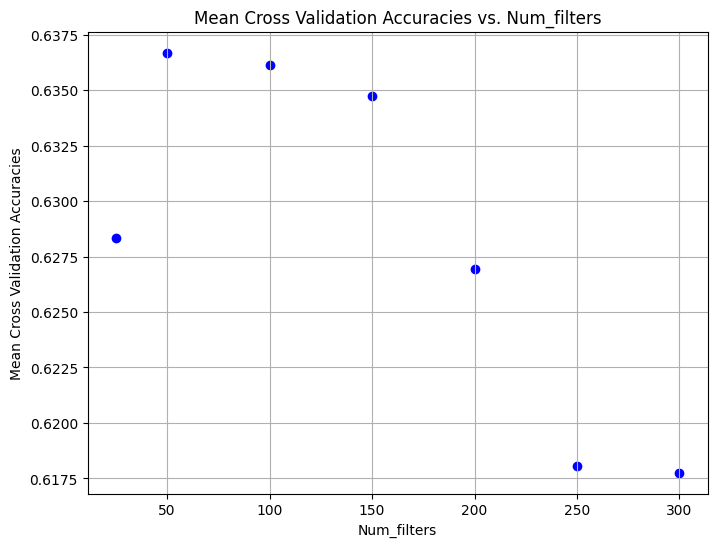

In [10]:
mean_accuracies = list(cross_validation_accuracies.values())
# Plot scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(filters, mean_accuracies, color='blue')
plt.title('Mean Cross Validation Accuracies vs. Num_filters')
plt.xlabel('Num_filters')
plt.ylabel('Mean Cross Validation Accuracies')
plt.grid(True)
plt.show()